In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

In [17]:
data = pd.read_csv(r"D:\Nouveau dossier\TitreRNCP_Bloc1\projet_prevision_energies_bloc5\datasets\data.csv", 
                   parse_dates=['timestamp'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66551 entries, 0 to 66550
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   timestamp                 66551 non-null  datetime64[ns]
 1   BIOMASS                   66551 non-null  float64       
 2   NUCLEAR                   66551 non-null  float64       
 3   SOLAR                     66551 non-null  float64       
 4   WIND_ONSHORE              66551 non-null  float64       
 5   consommation_totale       66551 non-null  float64       
 6   production_totale         66551 non-null  float64       
 7   taux_couverture_pourcent  66551 non-null  float64       
 8   balancing_energetique     66551 non-null  float64       
 9   temperature               66549 non-null  float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 5.1 MB


In [18]:
data.isnull().sum()

timestamp                   0
BIOMASS                     0
NUCLEAR                     0
SOLAR                       0
WIND_ONSHORE                0
consommation_totale         0
production_totale           0
taux_couverture_pourcent    0
balancing_energetique       0
temperature                 2
dtype: int64

In [19]:
data["temperature"].fillna(value=data["temperature"].interpolate(method='linear'), inplace=True)
data.isnull().sum()

timestamp                   0
BIOMASS                     0
NUCLEAR                     0
SOLAR                       0
WIND_ONSHORE                0
consommation_totale         0
production_totale           0
taux_couverture_pourcent    0
balancing_energetique       0
temperature                 0
dtype: int64

In [20]:
data.describe()

,timestamp,BIOMASS,NUCLEAR,SOLAR,WIND_ONSHORE,consommation_totale,production_totale,taux_couverture_pourcent,balancing_energetique,temperature
count,66551,66551.000000,66551.000000,66551.000000,66551.000000,66551.000000,66551.000000,66551.000000,66551.000000,66551.000000
mean,2021-10-18 10:00:00,362.295052,39327.026709,1924.243678,4207.093455,51159.789996,45820.602350,91.307086,-5339.187646,13.462611
min,2017-12-31 23:00:00,21.000000,0.000000,0.000000,0.000000,28657.000000,317.000000,0.607466,-52900.000000,-7.000000
25%,2019-11-25 04:30:00,323.000000,34714.500000,0.000000,1831.000000,42797.000000,40875.000000,81.233202,-10356.000000,8.300000
50%,2021-10-18 10:00:00,344.000000,39872.000000,253.000000,3172.000000,49340.000000,45813.000000,91.881975,-4067.000000,12.900000
75%,2023-09-11 15:30:00,367.000000,44083.000000,3146.000000,5771.000000,58486.000000,51591.000000,101.701734,779.500000,18.500000
max,2025-08-04 21:00:00,1773.000000,109356.000000,30734.000000,21538.000000,94912.000000,135026.000000,369.849390,84927.000000,41.700000
std,NaN,80.833275,8038.412153,2912.275833,3174.589401,11189.566046,8775.644698,16.151332,8603.628150,7.153843


In [26]:
df = data.melt(id_vars="timestamp", value_vars=["BIOMASS", "NUCLEAR", "SOLAR", "WIND_ONSHORE", 
                                              "consommation_totale", "production_totale", 
                                              "taux_couverture_pourcent", "balancing_energetique",
                                              "temperature"], var_name="unique_id", value_name="y")
df.rename(columns={"timestamp": "ds"}, inplace=True)
df.dropna(subset=['y'], inplace=True)
df.sort_values(['unique_id', 'ds'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,ds,unique_id,y
0,2017-12-31 23:00:00,BIOMASS,295.0
1,2018-01-01 00:00:00,BIOMASS,293.0
2,2018-01-01 01:00:00,BIOMASS,293.0
3,2018-01-01 02:00:00,BIOMASS,294.0
4,2018-01-01 03:00:00,BIOMASS,294.0


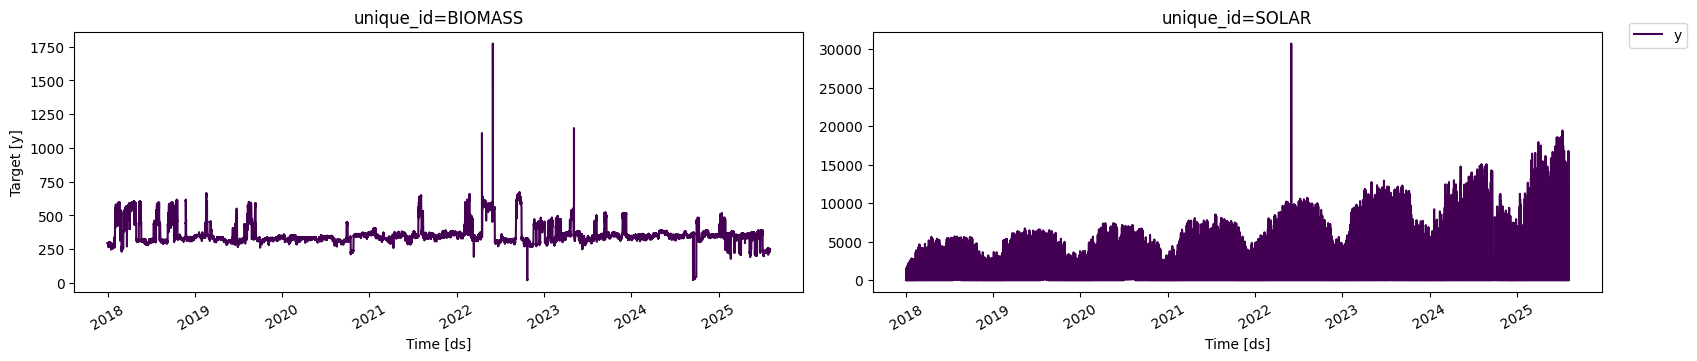

In [27]:
plot_series(df=df, ids=["BIOMASS", "SOLAR"], palette="viridis")

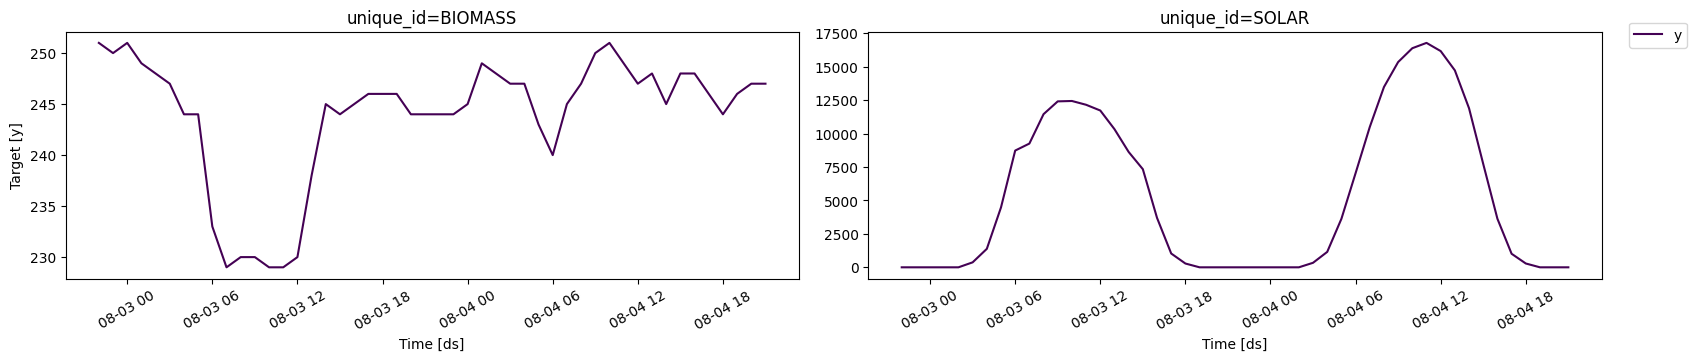

In [28]:
plot_series(df=df, ids=["BIOMASS", "SOLAR"], max_insample_length=48, palette="viridis")

### Baseline models

In [29]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [37]:
horizon = 24

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=24),
    SeasonalNaive(season_length=24)
]

sf = StatsForecast(models=models, freq="H")
sf.fit(df=df)
preds = sf.predict(h=horizon)

In [38]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BIOMASS,2025-08-04 22:00:00,247.0,362.295052,246.458333,244.0
1,BIOMASS,2025-08-04 23:00:00,247.0,362.295052,246.458333,244.0
2,BIOMASS,2025-08-05 00:00:00,247.0,362.295052,246.458333,245.0
3,BIOMASS,2025-08-05 01:00:00,247.0,362.295052,246.458333,249.0
4,BIOMASS,2025-08-05 02:00:00,247.0,362.295052,246.458333,248.0


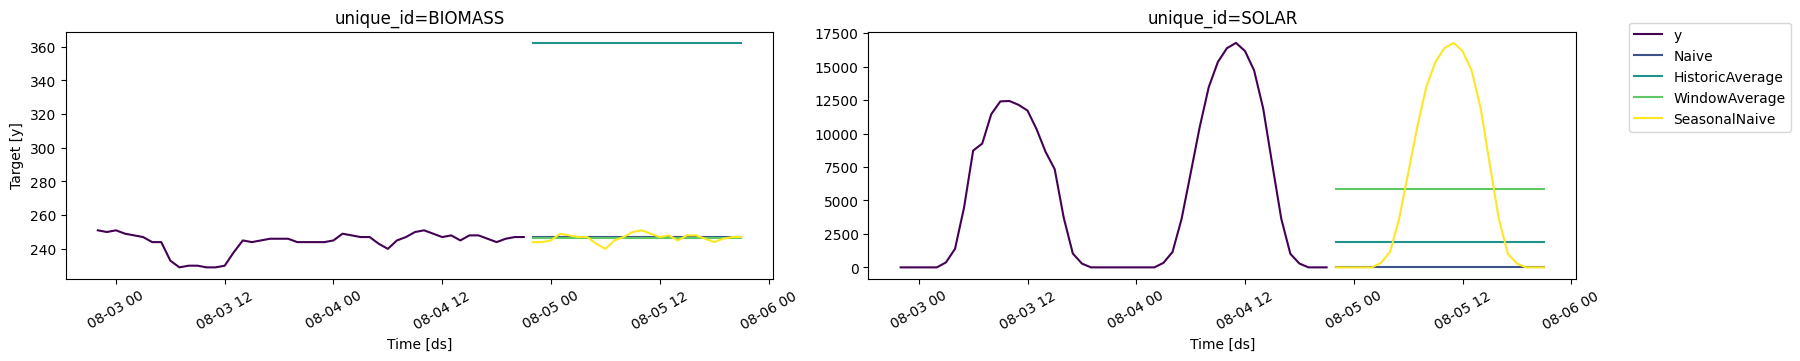

In [39]:
plot_series(
    df=df, 
    forecasts_df=preds, 
    ids=["BIOMASS", "SOLAR"], 
    max_insample_length=48, 
    palette="viridis")

### Evaluate baseline models

In [ ]:
test = df.groupby("unique_id").tail(24)
train = df.drop(test.index).reset_index(drop=True)

In [41]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(test, preds, 'left', ['ds', 'unique_id'])
eval_df.head()

,ds,unique_id,y,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,2025-08-03 22:00:00,BIOMASS,244.0,244.0,362.336841,241.333333,251.0
1,2025-08-03 23:00:00,BIOMASS,244.0,244.0,362.336841,241.333333,250.0
2,2025-08-04 00:00:00,BIOMASS,245.0,244.0,362.336841,241.333333,251.0
3,2025-08-04 01:00:00,BIOMASS,249.0,244.0,362.336841,241.333333,249.0
4,2025-08-04 02:00:00,BIOMASS,248.0,244.0,362.336841,241.333333,248.0


In [42]:
evaluation = evaluate(
    eval_df,
    metrics=[mae],
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BIOMASS,mae,2.875000,115.878507,5.236111,6.958333
1,NUCLEAR,mae,3687.041667,3230.425283,5261.479167,4883.083333
2,SOLAR,mae,5835.458333,5602.958333,5801.777778,1256.708333
3,WIND_ONSHORE,mae,821.375000,1044.544766,943.479167,881.166667
4,balancing_energetique,mae,5385.458333,13846.222616,5060.958333,4885.958333


In [43]:
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,2557.228606,4352.181146,3159.776669,2544.184265


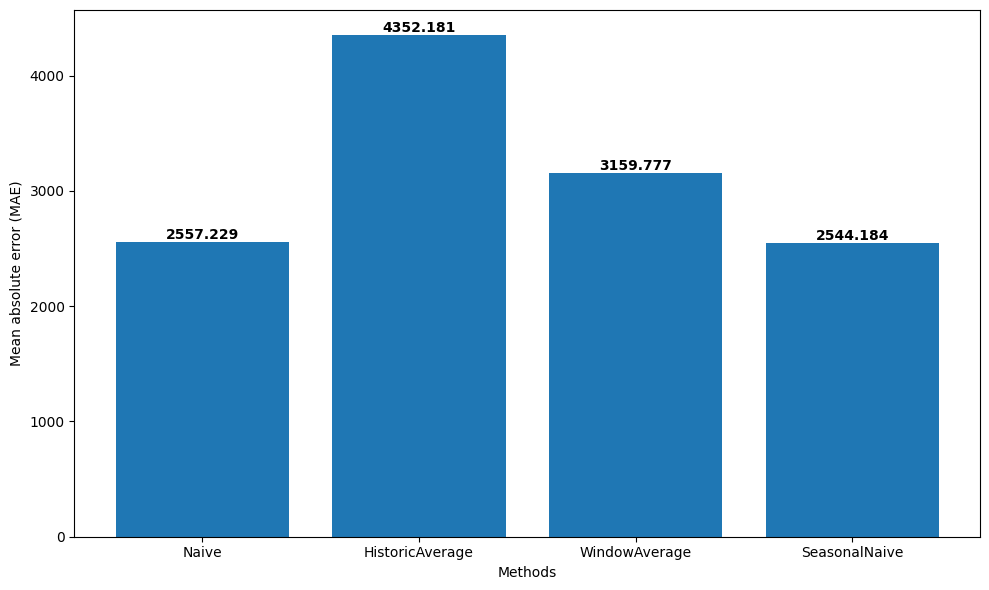

In [44]:
methods = evaluation.columns[1:].tolist()  
values = evaluation.iloc[0, 1:].tolist() 

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

In [45]:
from statsforecast.models import AutoARIMA

In [48]:
unique_ids = ["consommation_totale", "production_totale"]

small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]

models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=24, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="H")
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics=[mae],
)
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,consommation_totale,mae,4840.859562,2293.829525,3653.416667,11666.830688,5358.673611,4072.000000
1,production_totale,mae,4607.674662,2942.308037,3610.875000,3622.822266,5989.152778,6896.291667


In [49]:
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval

,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,4724.267112,2618.068781,3632.145833,7644.826477,5673.913194,5484.145833


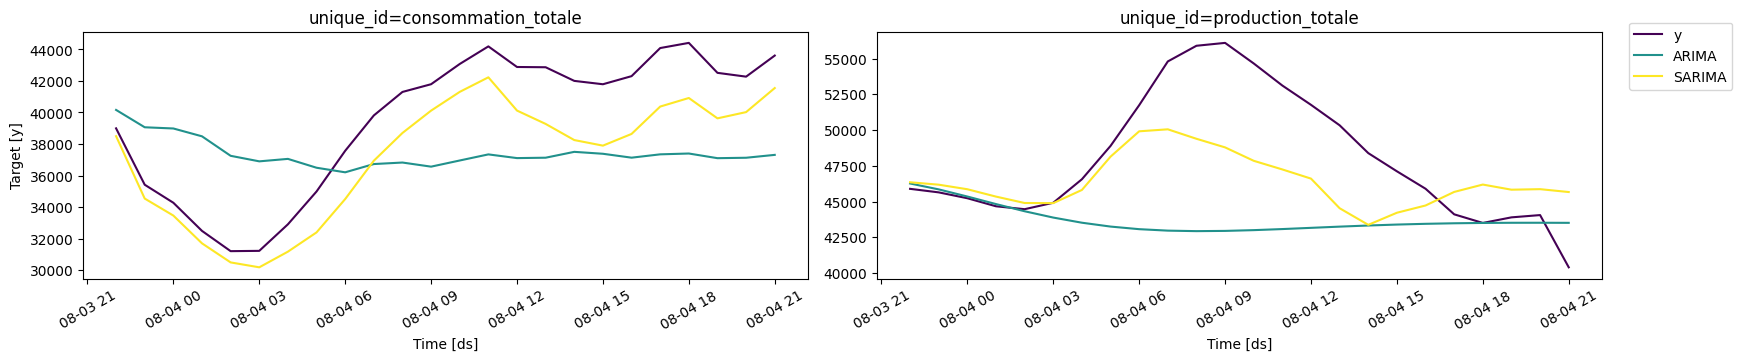

In [50]:
plot_series(
    df=df, 
    forecasts_df=arima_preds, 
    ids=unique_ids, 
    max_insample_length=24, 
    palette="viridis")

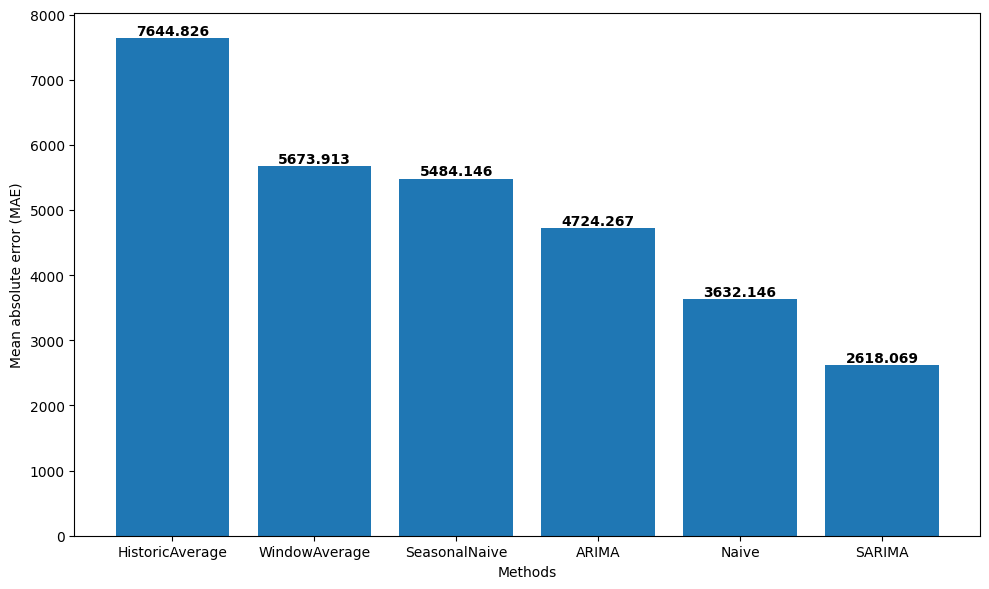

In [51]:
methods = arima_eval.columns[1:].tolist()  
values = arima_eval.iloc[0, 1:].tolist() 

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()

### Cross-validation

In [54]:
small_df = train[train["unique_id"].isin(unique_ids)]

models = [
    SeasonalNaive(season_length=24),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=24, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
cv_df = sf.cross_validation(
    h=horizon,
    
    df=small_df,
    n_windows=25,
    step_size=horizon,
    refit=True
)

cv_df.head()

KeyboardInterrupt: 

In [ ]:
plot_series(
    df=small_df, 
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1), 
    ids=unique_ids, 
    max_insample_length=5*24, 
    palette="viridis")

In [ ]:
cv_eval = evaluate(
    cv_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_eval